In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import numpy as np
import pandas as pd
import math as m
from itertools import product
import time as t

import pickle

from matplotlib import pyplot as plt

In [3]:
# Specific imports
from da_utils import plot_diff_all, plot_gem0_scan, write_gem0_offline, write_gem0_fromfile, write_gem0_fromcpo

In [4]:
# Most general variables
xlabels = ['te_value', 'ti_value', 'te_ddrho', 'ti_ddrho']
ylabels = ['te_transp_flux', 'ti_transp_flux']

n_fts=8

In [ ]:
### To create GEM0 scan files:

date_now = '20240201'

#file_in = "../../muscle3/ref_train_data_5000.csv"
#file_in = "gem0_new_data_20231215.csv"
#file_in = "gem0py_lhc_20240110_all.csv"

# coming back to 5000 full grid GEM0 data
#file_in = "gem0_new_data_20231208.csv"
# ... but on corrected radial locations
#file_in = "gem0_new_data_20231215.csv"
# ... newly generated such reading
file_in = 'gem0py_new_20240201.csv'
# LHC sample of size 12000
#file_in = 'gem0py_new_20240123.csv'

modtype="gpr"
codename="gem0py"

### Read inputs
data = pd.read_csv(file_in)
data_x = data[xlabels]
data_y = data[ylabels]
x = np.array(data_x)

# Create scan files
print("Creating scan files")

remainder_file_path = f"scan_{codename}{modtype}_remainder_"
remainder_file_date = date_now
st_t = t.time()

scan_data = [[plot_gem0_scan(x,input_number=i,output_number=o, flag_plot=False, file_name_suf=date_now, extend_factor=0.05, \
                               cut_option='file', remainder_values=f"{remainder_file_path}{xlabels[i]}_{remainder_file_date}", \
                             ) for i in range(len(xlabels))] for o in range(len(ylabels))]
print("Time to create scan files: ", t.time()-st_t)

scan_data_perft = []

# Reshape dictionaries
for n_ft in range(n_fts):
     scan_data_perft.append({(f"{xlabels[i]}_{ylabels[j]}",k): scan_data[j][i][(f"ft{n_ft}",k)] for i,j,k in product(range(len(xlabels)),range(len(ylabels)),['x','y'])})	

# Write down scan files
#date_last = '20240116'

for n_ft in range(n_fts):
     s = scan_data_perft[n_ft]
     spd = pd.DataFrame.from_dict(s)
     spd.to_csv(f"scan_{codename}py_{date_now}_ft{n_ft}.csv")


In [ ]:
# # Test: reading a multi-indexed dataframe
# test_df = pd.read_csv("scan_gem0_remainder_te_value.csv", header=[0, 1], index_col=0,)

# test_df = test_df[(f"ft{0}", xlabels[0])]

# test_array = np.array(test_df)
# print(test_array)

In [ ]:
# To create surrogate scan files:

#!cd ../../../EasySurrogate && pip install . && cd tests/gem_gp && for((i=0;i<8;i++)); do python3 test_model_ann.py ${i} 20231218 && cp scan_${i}.csv ../../../MFW/uq/basicda/scan_gem0surr_20240105_ft${i}.csv ; done && cd ../../../MFW/uq/basicda

!cd ../../../EasySurrogate && pip install . && cd tests/gem_gp && for((i=0;i<8;i++)); do python3 test_model.py ${i} 20231212 && cp scan_${i}.csv ../../../MFW/uq/basicda/scan_gem0surr_20240105_ft${i}.csv ; done && cd ../../../MFW/uq/basicda


In [10]:
# To plot the difference between GEM0 and surrogate, and their comparison

date = '20240201'
surtype = 'gpr'
codename = 'gem0py'

file_pref_gem0 = f"{codename}py_{date}"
file_pref_surr = f"{codename}{surtype}_{date}"

save_file = f"{codename}vs{surtype}_{date}_0.pdf"

plot_diff_all(file_pref_1=file_pref_gem0, file_pref_2=file_pref_surr, save_file=save_file)

!mv *gem0pyvsgpr_20240201_0.pdf ../../..

In [ ]:
# To generate a dataset of LHCS GEM0 evaluations
#nft = 8
date = '20240125'

file_in = 'gem0py_new_20240123.csv'

save_filename=f"gem0py_lhc_{date}_ft"

n_samples_p_ft = 1500

for i in range(n_fts):
    
    print(f"flux tube number: {i}")

    write_gem0_offline(n_samples=n_samples_p_ft, n_ft=i, filename=save_filename, file_in=file_in)


In [ ]:
# To generate an expanded dataset of GEM0 evaluations

from da_utils import write_gem0_expanded

datenow = '20240126'
save_filename = f"gem0py_new_{datenow}.csv"

file_old = "gem_648_data.csv"

expand_factor = 1.0

write_gem0_expanded(file_old, save_filename, expand_factor=expand_factor, calloption=2)

In [ ]:
# Add new readings to a training data set

from da_utils import merge_result_csv

code="gem0py"

date_old = "20240126"
date_new = "20240129"
date_now = "20240129"

file_old = f"{code}_new_{date_old}.csv"
file_new = f"test_{code}_{date_new}.csv"
file_tot = f"{code}_new_{date_now}.csv"

merge_result_csv([file_old, file_new], file_tot)


In [ ]:
# To generate a dataset of GEM0 evaluations for given input file

from da_utils import write_gem0_fromfile

# 1) Testing an new point saved by a workflow during the run
# filename_in = 'new_surrogate_points_it98.csv'
# filename_out = 'test_gem0py_20240129.csv'

# 2) A sample generated as a full grid around the final point of the worflow
# ATTENTION: last coretransp, coreprof, equilibrium have to be copied to /uq/basicda/
date = '20240202'
filename_in = f"gem0py_newpoint_{date}.csv"
filename_out = f"gem0py_new_{date}.csv"

write_gem0_fromfile(filename_in, filename_out)


In [8]:
# temporary: merge generated csv file into one, adding a column with the flux tube number

import glob

date = '20240125'
path = f"gem0py_lhc_{date}_ft*.csv" 

all_files = glob.glob(path)
df_from_each_file = [pd.read_csv(f) for f in all_files]

for i in range(len(df_from_each_file)):
    df_from_each_file[i]['ft'] = i

df_merged = pd.concat(df_from_each_file, ignore_index=True, sort=False)
df_merged.to_csv( f"gem0py_lhc_{date}_all.csv")


In [ ]:
# copy EasySurrogate campaign objects and replace model objects

In [ ]:
# Reformating: read the M3-WF resulting CSV and save the last point in format row: values, columns: Te/i gradTe/i ft

#import re

naming_map = {
    'te_value' : 'Te',
    'ti_value' : 'Ti',
    'te_ddrho' : 'dTe',
    'ti_ddrho' : 'dTi',
    'te_transp_flux': 'flux-Te',
    'ti_transp_flux': 'flux-Ti',    
    'diff_te': 'diff-Te',
    'diff_ti': 'diff-Ti',
    'vconv_te': 'vconv-Te',
    'vconv_ti': 'vconv-Ti',
}

dateorig = '20240202'
datenow  = '20240202'
code = 'gem0'
file_in = f"res_{code}_{dateorig}.csv"
file_out = f"final_point_{code}_{datenow}.csv"

#def find(name, data=data): return [ s for s in np.array(data.columns) if re.findall(name, s) ]

header = [v+'-ft'+str(j) for (k,v),j in product(naming_map.items(),range(1,9))]

data = pd.read_csv(file_in, sep=' ', header=None, names=header, usecols=[i for i in range(len(header))])

#print(header) ###DEBUG
#print(data.iloc[0]) ###DEBUG
#print(data.describe()) ##DEBUG

last_ind = -1
last_reading = data.iloc[last_ind]

nfts = 8

data_list_new = []

for i in range(nfts):

    element = {x:last_reading[f"{naming_map[x]}-ft{i+1}"] for x in xlabels}
    element['ft'] = i

    data_list_new.append(element)

data_new = pd.DataFrame(data_list_new)
data_new.to_csv(file_out)


In [ ]:
# Call pyGEM0 for single file - test why calling it for CPO and a value differs!

dateorig = '20240201'
datenow  = '20240201'
code = 'gem0'

file_in = f"final_point_{code}_{datenow}.csv"
file_out = f"test.csv"

pr_filename = 'gem0_coreprof_in.cpo'
eq_filename = 'gem0_equilibrium_in.cpo'
tr_filename = 'gem0_coretransp_in.cpo'

write_gem0_fromcpo(pr_filename, eq_filename, tr_filename)

write_gem0_fromfile(file_in, file_out)

In [ ]:
# Create a new full-product grid of profile values around a given point

from da_utils import write_profs_fromfile_grid

date = '20240202'

file_in  = f"final_point_gem0_{date}.csv"
file_out = f"gem0py_newpoint_{date}.csv"

write_profs_fromfile_grid(file_in, file_out, num_steps=2)

[-2.1765855587273144]

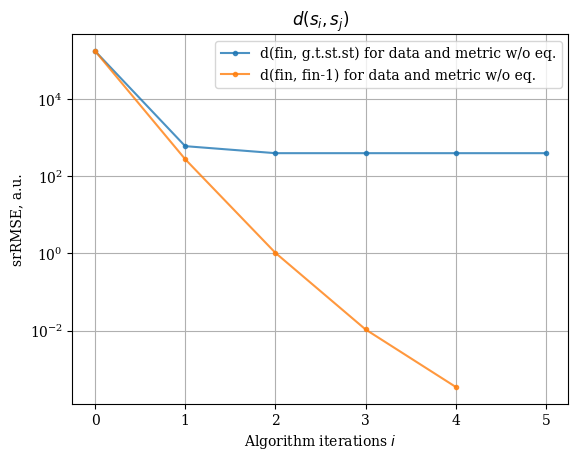

In [6]:
# Plot convergence of state disctance for Retraining algo
import sys
sys.path.append(f"/u/yyudin/code/MFW/muscle3/src/")
from muscle_utils.utils import plot_state_conv

# A) w/o equil
filenames = ['retr_algo_conv_2', ]
labels = ['data and metric w/o eq.',]

# B) with equil
#filenames = ['retr_algo_conv_eqmetr', 'retr_algo_conv_eqmetr_eqdata']
#labels = ['data w/o eq.', 'data w/ eq.']

data_df_list = []

for filename in filenames:
    data_df_list.append(pd.read_csv(f"{filename}.csv"))

plot_state_conv(data_df_list, filenames[0], normalised=False, label_sufixes=labels)


In [5]:
# Save data on the Retraining algo convergence


filename = 'retr_algo_conv_2'
data_dict = {
    'it'               : [0, 1, 2, 3, 4, 5,],
    'd_fin_gtstst' :     [176495.8859822613, 603.4057452947857, 396.9942234, 396.9009948, 396.9008822, 396.9008932, ] ,
    #'d_fin_gtststs'    : [603.4057452947857, 396.9942234314026, 396.9009948076408, 396.90088219565587, 396.90089323357563,],
    'd_fin_prevfin'    : [177104.3934354466, 277.10771108302293, 1.0398953618411646, 0.01074603640113972, 0.00034824677236947895, 'NaN' ],
}


# filename = 'retr_algo_conv_eqmetr'
# data_dict = {
#     'it'               : [0, 1, 2, 3, 4, 5, 6, ],
#     'd_fin_gtstst' : [88251.68127, 6684.846317, 561.1207998, 569.6313399, 569.6648542, 569.6658439, 569.665872],
#     'd_fin_prevfin'    : [81224.62621, 6415.35766, 35.08944019, 0.3278917823, 0.006191929644,0.0001025095243, 'NaN',],
# }


# filename = 'retr_algo_conv_eqmetr_eqdata'
# data_dict = {
#     'it'               : [0, 1, 2, 3, 4, 5, 6, ],
#     'd_fin_gtstst' : [88251.68127, 5277.631086, 562.533902, 564.4172435, 564.9457487, 564.9453184, 564.9449925,],
#     'd_fin_prevfin'    : [82685.02261, 4994.789405, 8.146175325, 5.238329788, 0.009808316204, 0.0003694048894, 'NaN',],
# }


data_df = pd.DataFrame(data_dict)
data_df.to_csv(f"{filename}.csv")

In [15]:
# # Testing the ProfileCPODecoder

# import os

# import easyvvuq as uq

# from base.profile_cpo_decoder import ProfileCPODecoder

# test_run_file = 'test_easyvvuq'
# test_run_dir = os.path.abspath(test_run_file)

# decoder = ProfileCPODecoder(cpo_filename='ets_coreprof_out.cpo')

# qoi = decoder.parse_sim_output({'run_dir':test_run_dir})

# print(qoi)

{'te_value_0': 1720.00051697186, 'ti_value_0': 1727.2526321474}


/tmp/ipykernel_46530/513445938.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['ft'].iloc[n_s_p_ft*(n_ft):n_s_p_ft*(n_ft+1)]= n_ft
/tmp/ipykernel_46530/513445938.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['ft'].iloc[n_s_p_ft*(n_ft):n_s_p_ft*(n_ft+1)]= n_ft
/tmp/ipykernel_46530/513445938.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['ft'].iloc[n_s_p_ft*(n_ft):n_s_p_ft*(n_ft+1)]= n_ft
/tmp/ip

Mean for Qe:
[ 79228.64128179 119782.17164565  14786.2287659   28731.62084013
  14111.87698176  20771.97286562  17563.46808502  32321.70316331]
naive CV for Qe:
[0.27498433 0.04017304 0.08557491 0.03862082 0.04363883 0.0378758
 0.05381561 0.08843446]
unweighted CV for Qe:
[0.33193058 0.06292552 0.16079804 0.0458399  0.04394751 0.03812843
 0.04699886 0.07347231]
weighted naive CV for Qe:
[0.2716535697803461, 0.04090879636006357, 0.08925920416389058, 0.04025090033650067, 0.04335489653168156, 0.03763990912924431, 0.05261851253811138, 0.08945178995622409]
weighted CV for Qe:
[0.2716535697803461, 0.04090879636006357, 0.08925920416389058, 0.04025090033650067, 0.04335489653168156, 0.03763990912924431, 0.05261851253811138, 0.08945178995622409]
Mean for Qi:
[ 40866.691405   439297.45962307   4290.70964164  26810.75343807
  30455.17763922  63463.96477882  58261.6303799   84816.11148619]
naive CV for Qi:
[0.23704631 0.04250256 0.0820291  0.04455335 0.04031437 0.04840126
 0.06963294 0.11072505]
un

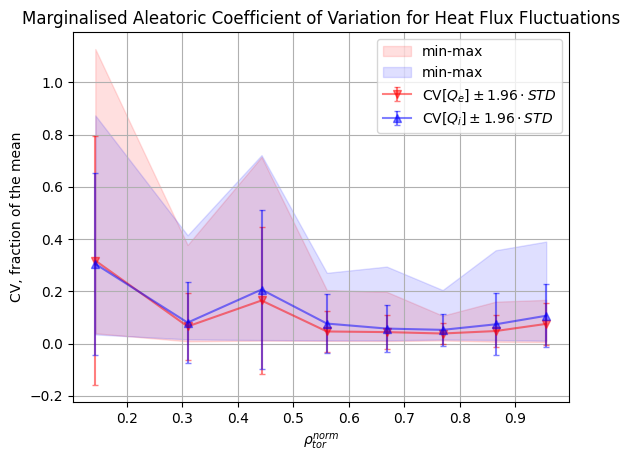

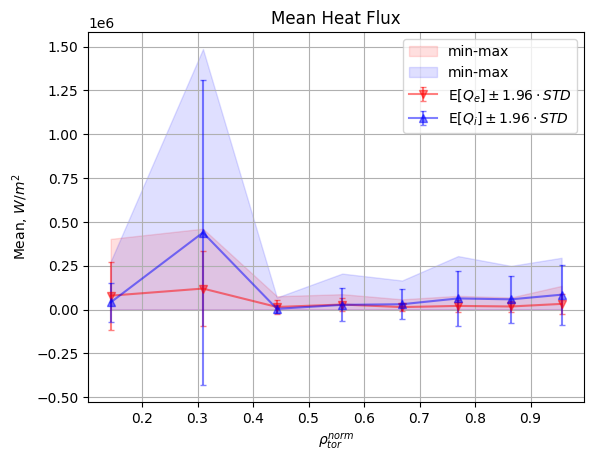

In [41]:
# To get the idea of flux variance as a function of rho (and temeperatures, gradients,...)

ft_coords = [0.143587306141853 , 0.309813886880875 , 0.442991137504578 , 0.560640752315521 , 0.668475985527039 , 0.769291400909424 , 0.864721715450287 , 0.955828309059143]

alpha_transp = 0.5

sp_cmap = {'e': 'r', 'i':'b'}
sp_mmap = {'e': 'v', 'i': '^'}

species = ['e', 'i']
filenames = [f"resuq_main_t{sp}_transp_flux_all_csldvnei_43.csv" for sp in species]

data_dfs = [pd.read_csv(filename) for filename in filenames]

n_params = 4
n_p_p_d = 3
n_s_p_ft = n_p_p_d ** n_params
n_fts = 8
    
# ATTENTION: to geat real average w.r.t. prior uncertainty on profiles, use weights from G-Legendre quadrature (n=3)
mean_weights_1d = [0.5555555555555556, 0.8888888888888888, 0.5555555555555556]
mean_weights_full = [m.prod(x) for x in product(mean_weights_1d, repeat=n_params)]
weighted_avg = lambda data,valcol,weightcol: (data[valcol]*data[weightcol]).sum() / data[weightcol].sum()
# -> looks like weighting does not change much

fig_cov, ax_cov = plt.subplots()
fig_avg, ax_avg = plt.subplots()

data_to_save = []

for data_df,sp in zip(data_dfs, species):

    # add ft column
    data_df = data_df.reindex(columns=data_df.columns.tolist() + ['ft'])
    for n_ft in range(n_fts):
        data_df['ft'].iloc[n_s_p_ft*(n_ft):n_s_p_ft*(n_ft+1)]= n_ft
    
    # Get the average of t?_transp_flux_std for ft
    colname1 = f"t{sp}_transp_flux_std"
    t_transp_flux_stds = np.array([data_df[data_df['ft']==n_ft][colname1].mean() for n_ft in range(n_fts)])

    colname2 = f"t{sp}_transp_flux"
    t_transp_flux_avgs = np.array([data_df[data_df['ft']==n_ft][colname2].mean() for n_ft in range(n_fts)])

    # (the spread of the mean values)
    t_transp_flux_avg_std = np.array([data_df[data_df['ft']==n_ft][colname2].std() for n_ft in range(n_fts)])
    t_transp_flux_avg_min = np.array([data_df[data_df['ft']==n_ft][colname2].min() for n_ft in range(n_fts)])
    t_transp_flux_avg_max = np.array([data_df[data_df['ft']==n_ft][colname2].max() for n_ft in range(n_fts)])

    t_transp_flux_covs = np.array([std/abs(avg) for std,avg in zip(t_transp_flux_stds, t_transp_flux_avgs)])

    print(f"Mean for Q{sp}:\n{t_transp_flux_avgs}")
    #ax_avg.plot(ft_coords, t_transp_flux_avgs, label=f"$\\mathrm{{E}}[Q_{sp}]$", marker='.', alpha=alpha_transp)
    ax_avg.errorbar(ft_coords, 
                    t_transp_flux_avgs, 
                    yerr=1.96*np.array(t_transp_flux_avg_std), 
                    label=f"$\\mathrm{{E}}[Q_{sp}] \\pm {1.96} \\cdot STD$", 
                    marker=sp_mmap[sp], 
                    color=sp_cmap[sp],
                    capsize=2, 
                    alpha=alpha_transp)
    ax_avg.fill_between(x=ft_coords,
                         y1=t_transp_flux_avg_min, 
                         y2=t_transp_flux_avg_max, 
                         alpha=0.25*alpha_transp, 
                         color=sp_cmap[sp],
                         label=f"min-max")

    # Output
    print(f"naive CV for Q{sp}:\n{t_transp_flux_covs}")
    #ax_cov.plot(ft_coords, t_transp_flux_covs, label=f"unweighted naive CV[Q_{sp}]", marker='.', alpha=alpha_transp)

    # Invert the sum and division operations!
    colname3 = f"t{sp}_transp_flux_cov"
    data_df[colname3] = data_df[colname1] / abs(data_df[colname2])
    t_transp_flux_tcovs = np.array([data_df[data_df['ft']==n_ft][colname3].mean() for n_ft in range(n_fts)])
    print(f"unweighted CV for Q{sp}:\n{t_transp_flux_tcovs}")
    #ax_cov.plot(ft_coords, t_transp_flux_tcovs, label=f"unweighted CV[Q_{sp}]", marker='.', alpha=alpha_transp)

    # Get the spread of CV values (for the flux tube)
    t_transp_flux_tcov_std = np.array([data_df[data_df['ft']==n_ft][colname3].std() for n_ft in range(n_fts)])
    t_transp_flux_tcov_min = np.array([data_df[data_df['ft']==n_ft][colname3].min() for n_ft in range(n_fts)])
    t_transp_flux_tcov_max = np.array([data_df[data_df['ft']==n_ft][colname3].max() for n_ft in range(n_fts)])

    # Add the weight column
    data_df = data_df.reindex(columns=data_df.columns.tolist() + ['weight'])
    for n_ft in range(n_fts):
        data_df['weight'].iloc[n_s_p_ft*(n_ft):n_s_p_ft*(n_ft+1)] = mean_weights_full

    # Get weighted average of t?_transp_flux_std for ft
    t_transp_flux_wstds  = [weighted_avg(data_df[data_df['ft']==n_ft], colname1, 'weight') for n_ft in range(n_fts)]
    t_transp_flux_wavgs  = [weighted_avg(data_df[data_df['ft']==n_ft], colname2, 'weight') for n_ft in range(n_fts)]
    t_transp_flux_twcovs = [weighted_avg(data_df[data_df['ft']==n_ft], colname3, 'weight') for n_ft in range(n_fts)]
    t_transp_flux_wcovs  = [std/abs(avg) for std,avg in zip(t_transp_flux_wstds, t_transp_flux_wavgs)]

    print(f"weighted naive CV for Q{sp}:\n{t_transp_flux_wcovs}")
    #ax_cov.plot(ft_coords, t_transp_flux_wcovs, label=f"weighted naive CV[Q_{sp}]", marker='.', alpha=alpha_transp)

    print(f"weighted CV for Q{sp}:\n{t_transp_flux_wcovs}")
    #ax_cov.plot(ft_coords, t_transp_flux_twcovs, label=f"CV[$Q_{sp}$]", marker='.', alpha=alpha_transp)
    ax_cov.errorbar(ft_coords, 
                    t_transp_flux_twcovs,
                      yerr=1.96*t_transp_flux_tcov_std, 
                      label=f"$\\mathrm{{CV}}[Q_{sp}] \\pm {1.96} \\cdot STD$", 
                      marker=sp_mmap[sp], 
                      color=sp_cmap[sp],
                      capsize=2, 
                      alpha=alpha_transp)
    ax_cov.fill_between(x=ft_coords, 
                        y1=t_transp_flux_tcov_min, 
                        y2=t_transp_flux_tcov_max, 
                        alpha=0.25*alpha_transp, 
                        color=sp_cmap[sp],
                        label=f"min-max")

    # # save a new dataframe
    # #data_df.drop('name', axis=1)
    # #data_df.drop('index')
    # data_to_save.append(data_df)

# df_to_save = pd.concat(data_to_save, axis=1)
# df_to_save.to_csv("gem_new_baseline.csv")

ax_cov.legend(loc='best')
ax_cov.grid('both')
ax_cov.set_xlabel(f"$\\rho_{{tor}}^{{norm}}$")
ax_cov.set_ylabel(f"CV, fraction of the mean")
ax_cov.set_title(f"Marginalised Aleatoric Coefficient of Variation for Heat Flux Fluctuations")
fig_cov.savefig('gem_flux_cov_pft.pdf')

ax_avg.legend(loc='best')
ax_avg.grid('both')
ax_avg.set_xlabel(f"$\\rho_{{tor}}^{{norm}}$")
ax_avg.set_ylabel(f"Mean, $W/m^{{2}}$")
ax_avg.set_title(f"Mean Heat Flux")
fig_avg.savefig('gem_flux_avg_pft.pdf')

In [6]:
# # Read and plot the aleatoric UQ campaign results
# import pickle

# filename = 'result_aleatoric_wf.pickle'
# filename = '../result_aleatoric_wf.pickle.20240220_1529'

# with open(filename, "r") as f:
#     data = pickle.load(f)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

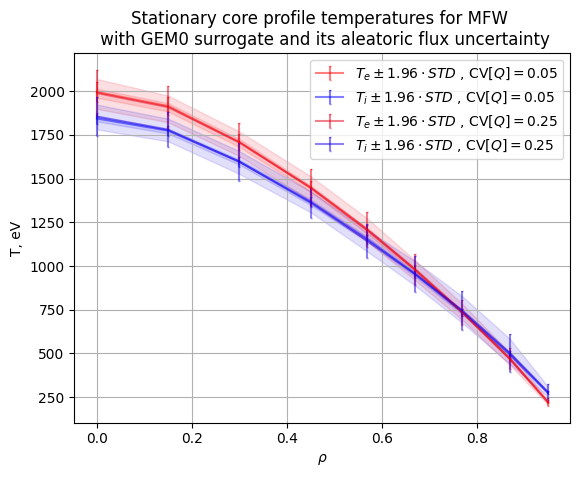

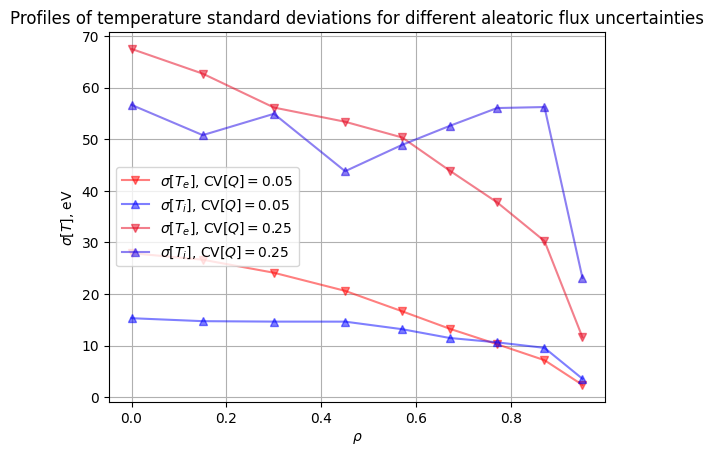

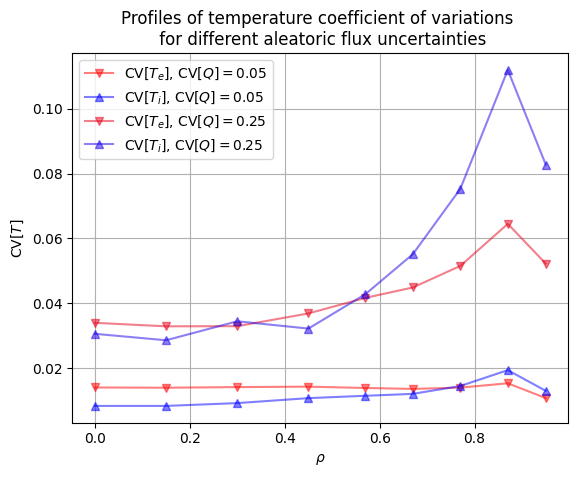

In [39]:
# Read a list of .pickle files with results of UQ campaign to analyse aleatroic uncertainty
#   in core profiles and plot its: KDE PDF fits, mean+/2sigma for profiles, sigma_y(sigma_x) dependency

import numpy as np
from matplotlib import pyplot as plt
import pickle

alpha_transp = 0.5

ind_coords = [0, 15, 30, 45, 57, 67, 77, 87, 95]
ft_coords = [0.143587306141853 , 0.309813886880875 , 0.442991137504578 , 0.560640752315521 , 0.668475985527039 , 0.769291400909424 , 0.864721715450287 , 0.955828309059143]
species = ['e', 'i']

color_step = 0.1
color_num = 10
# sp_cmaps = {'e':[(1.-color_step*i, 0.5*color_step*i, 0.5*color_step*i) for i in range(0,color_num)], 
#             'i':[(color_step*i,    0.25*color_step*i,    1.-color_step*i ) for i in range(0,color_num)]}

sp_cmaps = {'e':[(1.-color_step*i, 0., color_step*i ) for i in range(0,color_num)], 
            'i':[(color_step*i ,   0., 1.-color_step*i ) for i in range(0,color_num)],
            'a':[(1.-color_step*3*i, 0., color_step*3*i) for i in range(0,color_num)]}

sp_mmap = {'e':'v', 'i':'^'}

# Read the files
# # A)
# result_filename_list = ['../result_aleatoric_wf.pickle.20240220_1750', '../result_aleatoric_wf.pickle.20240220_1817']
# cov_inputs = [0.05, 0.1,] # 0.25]

# # B)
# result_filename_list = ['../result_aleatoric_wf_cv0.01.pickle', '../result_aleatoric_wf_cv0.05.pickle']
# cov_inputs = [0.01, 0.05]

# C)
result_filename_list = ['../results_aletoric_20240222/result_aleatoric_wf_cv0.01.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.05.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.1.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.2.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.25.pickle']
cov_inputs = [float(".".join([f.split('.')[-3][-1],f.split('.')[-2]])) for f in result_filename_list]

#D)
result_filename_list = ['../results_aletoric_20240222/result_aleatoric_wf_cv0.05.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.25.pickle']
cov_inputs = [float(".".join([f.split('.')[-3][-1],f.split('.')[-2]])) for f in result_filename_list]

output_columns =  ["te_value_0", "te_value_15", "te_value_30", "te_value_45", "te_value_57", "te_value_67", "te_value_77", "te_value_87", "te_value_95", 
                   "ti_value_0", "ti_value_15", "ti_value_30", "ti_value_45", "ti_value_57", "ti_value_67", "ti_value_77", "ti_value_87", "ti_value_95",]

#output_columns = [f"t{sp}_value_{i}" for sp,i in product(['e','i'],[i for i in range(100)])]

data_list = []
# should be (at least) 3D data-structure: n_qoi x n_statistics x n_runs
for filename in result_filename_list:
    with open(filename, "rb") as f:
        data = pickle.load(f)
    #data_list.append(data.raw_data['statistical_moments'])
    data_list.append(data.raw_data)

## Mean +/- confidence intervals
sigma_factor = 1.96
fig_prof, ax_prof = plt.subplots()
fig_sigrho, ax_sigrho = plt.subplots()
fig_covrho, ax_covrho = plt.subplots()

for run_i, data in enumerate(data_list):
    for sp in species:
        y    = np.array([float(data['statistical_moments'][f"t{sp}_value_{c}"]['mean'][0][0]) for c in ind_coords])
        std  = np.array([float(data['statistical_moments'][f"t{sp}_value_{c}"]['std'][0][0]) for c in ind_coords])
        yupp = np.array([float(data['percentiles'][f"t{sp}_value_{c}"]['p90'][0]) for c in ind_coords])
        ylow = np.array([float(data['percentiles'][f"t{sp}_value_{c}"]['p10'][0]) for c in ind_coords])
        cov  = np.array([std_j / abs(y_j) for y_j,std_j in zip(y,std)])
        #std_mult = [sigma_factor * s for s in std]
        #print(type(std[0]))

        ax_prof.errorbar(x=np.array(ind_coords)/100, 
                        y=y,
                        yerr=std*sigma_factor,
                        alpha=alpha_transp,
                        capsize=1,
                        color=sp_cmaps[sp][run_i],
                        #marker=sp_mmap[sp],
                        label=f"$T_{sp} \\pm {sigma_factor} \\cdot STD$ , $\\mathrm{{CV}}[Q]={cov_inputs[run_i]}$"
                        )

        ax_prof.fill_between(x=np.array(ind_coords)/100,
                             y1=ylow,
                             y2=yupp,
                             alpha=0.25*alpha_transp,
                             color=sp_cmaps[sp][run_i],
                             #label=f"$T_{sp} \\pm {sigma_factor} \\cdot STD$ , $\mathrm{{CV}}[Q]={cov_inputs[run_i]}$"
                             )

        ax_sigrho.plot(np.array(ind_coords)/100,
                       std,
                       alpha=alpha_transp,
                       marker=sp_mmap[sp],
                       color=sp_cmaps[sp][run_i],
                       label=f"$\\sigma[T_{sp}]$, $\\mathrm{{CV}}[Q]={cov_inputs[run_i]}$",
                      )             

        ax_covrho.plot(np.array(ind_coords)/100,
                       cov,
                       alpha=alpha_transp,
                       marker=sp_mmap[sp],
                       color=sp_cmaps[sp][run_i],
                       label=f"$\\mathrm{{CV}}[T_{sp}]$, $\\mathrm{{CV}}[Q]={cov_inputs[run_i]}$",
                      )             

ax_prof.set_xlabel(f"$\\rho$")
ax_prof.set_ylabel(f"T, eV")
ax_prof.set_title(f"Stationary core profile temperatures for MFW \n with GEM0 surrogate and its aleatoric flux uncertainty")
ax_prof.grid('both')
ax_prof.legend(loc='best') 
fig_prof.savefig('gem0surr_aleatoric_profiles.pdf')

ax_covrho.set_xlabel(f"$\\rho$")
ax_covrho.set_ylabel(f"$\\mathrm{{CV}}[T]$")
ax_covrho.set_title(f"Profiles of temperature coefficient of variations \n for different aleatoric flux uncertainties")
ax_covrho.grid('both')
ax_covrho.legend(loc='best') 
fig_covrho.savefig('gem0surr_aleatoric_covrho.pdf')

ax_sigrho.set_xlabel(f"$\\rho$")
ax_sigrho.set_ylabel(f"$\\sigma[T]$, eV")
ax_sigrho.set_title(f"Profiles of temperature standard deviations for different aleatoric flux uncertainties")
ax_sigrho.grid('both')
ax_sigrho.legend(loc='best') 
fig_sigrho.savefig('gem0surr_aleatoric_sigrho.pdf')


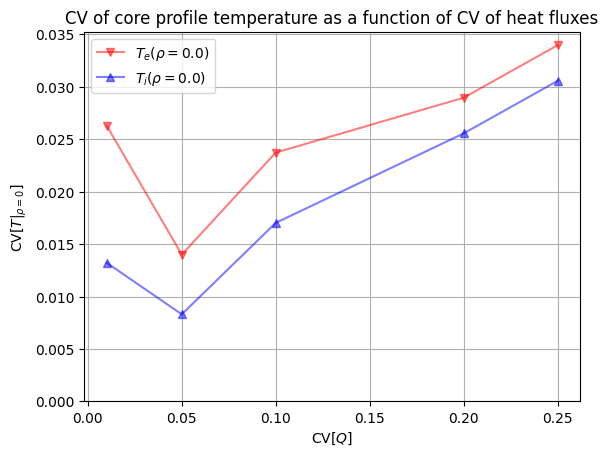

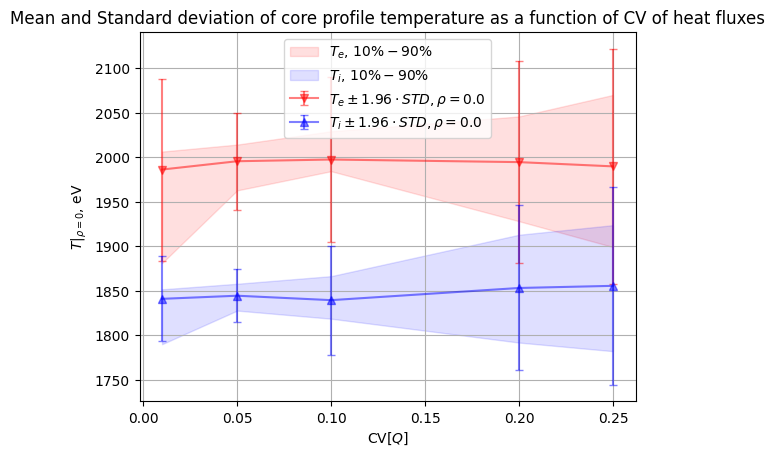

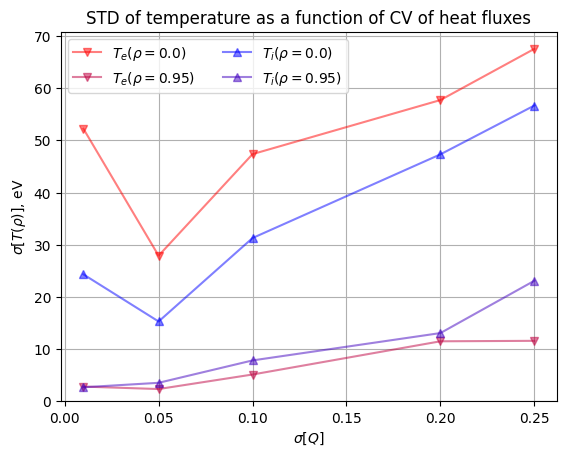

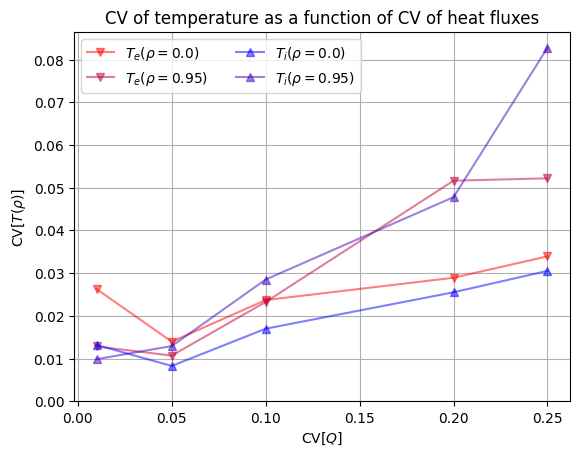

In [33]:
##  Sigma-of-sigma plot
import numpy as np
from matplotlib import pyplot as plt
import pickle

species = ['e', 'i']

# #1)
# ind_coords = [0, 15, 30, 45, 57, 67, 77, 87, 95]
# ft_coords = [0.143587306141853 , 0.309813886880875 , 0.442991137504578 , 0.560640752315521 , 0.668475985527039 , 0.769291400909424 , 0.864721715450287 , 0.955828309059143]

# output_columns =  ["te_value_0", "te_value_15", "te_value_30", "te_value_45", "te_value_57", "te_value_67", "te_value_77", "te_value_87", "te_value_95", 
#                    "ti_value_0", "ti_value_15", "ti_value_30", "ti_value_45", "ti_value_57", "ti_value_67", "ti_value_77", "ti_value_87", "ti_value_95",]

#2)
ind_coords = [0, 95]
ft_coords = [0.143587306141853, 0.955828309059143]

output_columns =  ["te_value_0", "te_value_95", 
                   "ti_value_0", "ti_value_95",]

result_filename_list = ['../results_aletoric_20240222/result_aleatoric_wf_cv0.01.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.05.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.1.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.2.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.25.pickle']
cov_inputs = [float(".".join([f.split('.')[-3][-1],f.split('.')[-2]])) for f in result_filename_list]


#output_columns = [f"t{sp}_value_{i}" for sp,i in product(['e','i'],[i for i in range(100)])]

alpha_transp = 0.5
color_step = 0.25
color_num = 10
# sp_cmaps = {'e':[(1.-color_step*i, 0.5*color_step*i, 0.5*color_step*i) for i in range(0,color_num)], 
#             'i':[(color_step*i,    0.25*color_step*i,    1.-color_step*i ) for i in range(0,color_num)]}

sp_cmaps = {'e':[(1.-color_step*i, 0., color_step*i ) for i in range(0,color_num)], 
            'i':[(color_step*i ,   0., 1.-color_step*i ) for i in range(0,color_num)],
            'a':[(1.-color_step*3*i, 0., color_step*3*i) for i in range(0,color_num)]}
sp_mmap = {'e':'v', 'i':'^'}

data_list = []
# should be (at least) 3D data-structure: n_qoi x n_statistics x n_runs
for filename in result_filename_list:
    with open(filename, "rb") as f:
        data = pickle.load(f)
    #data_list.append(data.raw_data['statistical_moments'])
    data_list.append(data.raw_data)

# Get the data

mean_outputs = []
sigma_outputs = []
cov_outputs = []

for data in data_list:
    #cov_inputs.append[cov] # either should be in data file, or a separate list hard-coded

    mean_outputs_loc = [data['statistical_moments'][qoi]['mean'][0][0] for qoi in output_columns]
    sigma_output_loc = [data['statistical_moments'][qoi]['std'][0][0] for qoi in output_columns]
    cov_outputs_loc  = [std/abs(avg) for avg,std in zip(mean_outputs_loc, sigma_output_loc)]
    
    mean_outputs.append(mean_outputs_loc)
    sigma_outputs.append(sigma_output_loc)
    cov_outputs.append(cov_outputs_loc)

mean_outputs_array = np.array(mean_outputs)
sigma_outputs_array = np.array(sigma_outputs)
cov_outputs_array = np.array(cov_outputs)

p10_outputs_array = np.array([[data['percentiles'][qoi]['p10'][0] for qoi in output_columns] for data in data_list])
p90_outputs_array = np.array([[data['percentiles'][qoi]['p90'][0] for qoi in output_columns] for data in data_list])

# Plot the data with each plot/line for a rho value (at 0)
fig_sigsig, ax_sigsig = plt.subplots()
fig_tcore, ax_tcore = plt.subplots()
output_columns_plot = ['te_value_0', 'ti_value_0']
inds_to_plot = [0,2]

for q_i,qoi in enumerate(output_columns_plot):
    words = qoi.split('_')
    sp = words[0][1]
    coord = int(words[-1])
    
    # plot CV_T0 (CV_Q)
    ax_sigsig.plot(cov_inputs, cov_outputs_array[:,inds_to_plot[q_i]], 
                   alpha=alpha_transp,
                   color=sp_cmaps[sp][0],
                   marker=sp_mmap[sp],
                   label=f"$T_{sp}(\\rho={coord/100})$")

    # plot E_T0 +/- V_T0 (CoV_Q)
    ax_tcore.errorbar(x=cov_inputs, 
                      y=mean_outputs_array[:,inds_to_plot[q_i]], 
                      yerr=sigma_factor*sigma_outputs_array[:,inds_to_plot[q_i]],
                      #fmt='.-',
                      alpha=alpha_transp,
                      capsize=3,
                      color=sp_cmaps[sp][0],
                      marker=sp_mmap[sp],
                      label=f"$T_{sp} \\pm {sigma_factor} \\cdot STD, \\rho={coord/100}$")
    
    ax_tcore.fill_between(cov_inputs,
                          y1=p10_outputs_array[:,inds_to_plot[q_i]],
                          y2=p90_outputs_array[:,inds_to_plot[q_i]],
                          alpha=0.25*alpha_transp,
                          color=sp_cmaps[sp][0],
                          #marker=sp_mmap[sp],
                          label=f"$T_{sp}$, $10\\%-90\\%$")

ax_sigsig.set_xlabel(f"$\\mathrm{{CV}}[Q]$")
ax_sigsig.set_ylabel(f"$\\mathrm{{CV}}[T\\vert_{{\\rho=0}}]$")
ax_sigsig.set_title(f"CV of core profile temperature as a function of CV of heat fluxes")
ax_sigsig.grid('both')
ax_sigsig.legend(loc='best')
ax_sigsig.set_ylim(ymin=0.0)
fig_sigsig.savefig("gem0surr_aleatoric_scan.pdf")

ax_tcore.set_xlabel(f"$\mathrm{{CV}}[Q]$")
ax_tcore.set_ylabel(f"$T\\vert_{{\\rho=0}}$, eV")
ax_tcore.set_title(f"Mean and Standard deviation of core profile temperature as a function of CV of heat fluxes")
ax_tcore.grid('both')
ax_tcore.legend(loc='best')
fig_tcore.savefig("gem0surr_aleatoric_scan_tcore.pdf")

# Plot the data with each plot/line for a rho value (multiple values)
fig_sigcovrho, ax_sigcovrho = plt.subplots()
fig_covcovrho, ax_covcovrho = plt.subplots()

output_columns_plot = output_columns

for q_i,qoi in enumerate(output_columns_plot):
    words = qoi.split('_')
    sp = words[0][1]
    coord = int(words[-1]) 

    # plot CV_T(r) (CV_Q)
    ax_sigcovrho.plot(cov_inputs, sigma_outputs_array[:,q_i], 
                   marker=sp_mmap[sp], 
                   alpha=alpha_transp,
                   color=sp_cmaps[sp][q_i%(len(output_columns_plot)//2)],
                   label=f"$T_{sp}(\\rho={coord/100})$")

    # plot CV_T(r) (CV_Q)
    ax_covcovrho.plot(cov_inputs, cov_outputs_array[:,q_i], 
                   marker=sp_mmap[sp], 
                   alpha=alpha_transp,
                   color=sp_cmaps[sp][q_i%(len(output_columns_plot)//2)],
                   label=f"$T_{sp}(\\rho={coord/100})$")

ax_sigcovrho.set_xlabel(f"$\\sigma[Q]$")
ax_sigcovrho.set_ylabel(f"$\\sigma[T(\\rho)]$, eV")
ax_sigcovrho.set_title(f"STD of temperature as a function of CV of heat fluxes")
ax_sigcovrho.grid('both')
ax_sigcovrho.legend(loc='best', ncol=2)
ax_sigcovrho.set_ylim(ymin=0.0)
fig_sigcovrho.savefig("gem0surr_aleatoric_scan_sig_trho.pdf")

ax_covcovrho.set_xlabel(f"$\\mathrm{{CV}}[Q]$")
ax_covcovrho.set_ylabel(f"$\\mathrm{{CV}}[T(\\rho)]$")
ax_covcovrho.set_title(f"CV of temperature as a function of CV of heat fluxes")
ax_covcovrho.grid('both')
ax_covcovrho.legend(loc='best', ncol=2)
ax_covcovrho.set_ylim(ymin=0.0)
fig_covcovrho.savefig("gem0surr_aleatoric_scan_cov_trho.pdf")

# Plot existing quantiles ?

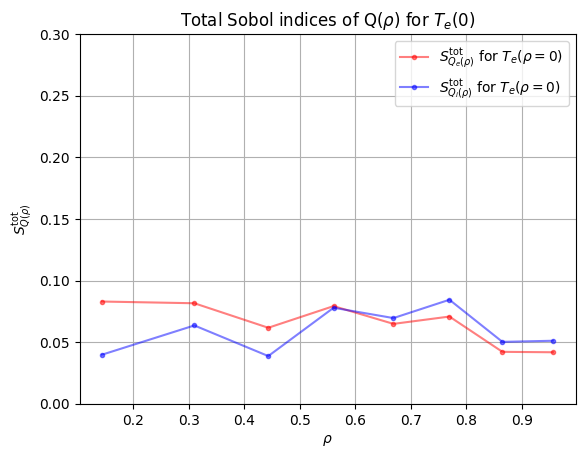

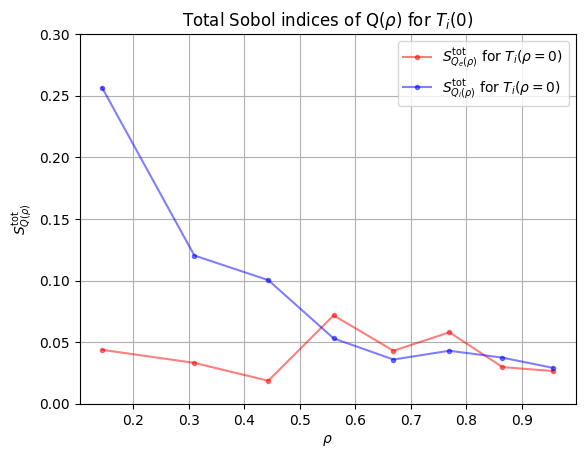

In [36]:
# Sobol indices for aleatoric algorithm (depends on previous 2 blocks)

alpha_transp = 0.5

ind_coords = [0, 15, 30, 45, 57, 67, 77, 87, 95]
ft_coords = [0.143587306141853 , 0.309813886880875 , 0.442991137504578 , 0.560640752315521 , 0.668475985527039 , 0.769291400909424 , 0.864721715450287 , 0.955828309059143]
species = ['e', 'i']

color_step = 0.1
color_num = 10

sp_cmaps = {'e':[(1.-color_step*i, 0., color_step*i ) for i in range(0,color_num)], 
            'i':[(color_step*i ,   0., 1.-color_step*i ) for i in range(0,color_num)],
            'a':[(1.-color_step*3*i, 0., color_step*3*i) for i in range(0,color_num)]}

sp_mmap = {'e':'v', 'i':'^'}


result_filename_list = ['../results_aletoric_20240222/result_aleatoric_wf_cv0.01.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.05.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.1.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.2.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.25.pickle']
cov_inputs = [float(".".join([f.split('.')[-3][-1],f.split('.')[-2]])) for f in result_filename_list]

output_columns =  ["te_value_0", "te_value_15", "te_value_30", "te_value_45", "te_value_57", "te_value_67", "te_value_77", "te_value_87", "te_value_95", 
                   "ti_value_0", "ti_value_15", "ti_value_30", "ti_value_45", "ti_value_57", "ti_value_67", "ti_value_77", "ti_value_87", "ti_value_95",]


#print(data['sobols_first']['te_value_0']) ###DEBUG

sobols_type = 'sobols_total'
sobol_err_type = 'conf_sobols_total'

# Plot the Sobol indices with each plot/line for a rho value (at 0)

output_columns_plot = ['te_value_0', 'ti_value_0']

for qoi_i,qoi in enumerate(output_columns_plot):

    fig_sobcov, ax_sobcov = plt.subplots()

    words_out = qoi.split('_')
    sp_out = words_out[0][1]
    coord_out = int(words[-1])

    sobol_array_tot = np.array([data[sobols_type][qoi][f"Q{sp_in}_{n_ft}"][0][0] for sp_in,n_ft in product(species,[i for i,_ in enumerate(ft_coords)])])
    norm_sob = sobol_array_tot.sum()

    for sp_in in species:
        
        sobol_array_loc = np.array([data[sobols_type][qoi][f"Q{sp_in}_{n_ft}"][0][0] for n_ft in range(len(ft_coords))])
        #norm_sob = sobol_array_loc.sum() # norm should be across all inputs (for all species)
        sobol_array_loc = sobol_array_loc / norm_sob

        # plot Sob_T0 (CV_Q_rho)
        ax_sobcov.plot(ft_coords,
                    sobol_array_loc,
                    marker='.', 
                    alpha=alpha_transp,
                    color=sp_cmaps[sp_in][0],
                    label=f"$S_{{Q_{sp_in}(\\rho)}}^{{\\mathrm{{tot}}}}$ for $T_{sp_out}(\\rho=0)$"
                    )

        # # Plot the congidence intervals for Sobol indices
        # sobol_errlo_array_loc = np.array([data[sobol_err_type][qoi][f"Q{sp_in}_{n_ft}"]['low'][0][0] for n_ft in range(len(ft_coords))])             
        # sobol_errhi_array_loc = np.array([data[sobol_err_type][qoi][f"Q{sp_in}_{n_ft}"]['high'][0][0] for n_ft in range(len(ft_coords))])            
        # norm_lo = sobol_errlo_array_loc.sum()
        # norm_hi = sobol_errhi_array_loc.sum()
        # sobol_errlo_array_loc = sobol_errlo_array_loc / norm_sob
        # sobol_errhi_array_loc = sobol_errhi_array_loc / norm_sob

        # ax_sobcov.fill_between(ft_coords,
        #             sobol_errlo_array_loc,
        #             sobol_errhi_array_loc, 
        #             alpha=0.25*alpha_transp,
        #             color=sp_cmaps[sp_in][0],
        #             #label=f"CI",
        #             )

    ax_sobcov.set_xlabel(f"$\\rho$")
    ax_sobcov.set_ylabel(f"$S_{{Q(\\rho)}}^{{\\mathrm{{tot}}}}$")
    ax_sobcov.set_title(f"Total Sobol indices of Q($\\rho$) for $T_{sp_out}(0)$")
    ax_sobcov.grid('both')
    ax_sobcov.legend(loc='best')
    ax_sobcov.set_ylim(ymin=0.0, ymax=0.3)
    fig_sobcov.savefig(f"gem0surr_aleatoric_sobol_rho_{qoi}.pdf")


In [10]:
# filename = '../result_aleatoric_wf.pickle.20240220_1750'
# with open(filename, "rb") as f:
#     data = pickle.load(f)

# for k,v in data.raw_data['statistical_moments'].items():
#     print(v['std'][0][0])

# for k,v in data.raw_data['statistical_moments'].items():
#     print(k)

data.raw_data.keys()

dict_keys(['statistical_moments', 'percentiles', 'sobols_first', 'sobols_total', 'conf_sobols_first', 'conf_sobols_total'])

CoV for te_value_0: 0    0.03397
dtype: float64
CoV for te_value_15: 0    0.032891
dtype: float64
CoV for te_value_30: 0    0.032935
dtype: float64
CoV for te_value_45: 0    0.036868
dtype: float64
CoV for te_value_57: 0    0.041674
dtype: float64
CoV for te_value_67: 0    0.044888
dtype: float64
CoV for te_value_77: 0    0.051533
dtype: float64
CoV for te_value_87: 0    0.064526
dtype: float64
CoV for te_value_95: 0    0.052254
dtype: float64
CoV for ti_value_0: 0    0.030574
dtype: float64
CoV for ti_value_15: 0    0.028584
dtype: float64
CoV for ti_value_30: 0    0.034445
dtype: float64
CoV for ti_value_45: 0    0.032192
dtype: float64
CoV for ti_value_57: 0    0.042814
dtype: float64
CoV for ti_value_67: 0    0.055168
dtype: float64
CoV for ti_value_77: 0    0.075352
dtype: float64
CoV for ti_value_87: 0    0.112063
dtype: float64
CoV for ti_value_95: 0    0.082826
dtype: float64


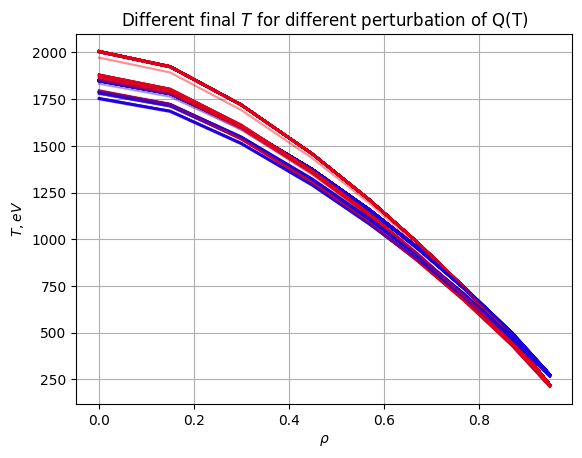

In [22]:
# Plotting various samples of Aleatoric algo
# (depends on previous)

import numpy as np
from matplotlib import pyplot as plt
import pickle

from cycler import cycler

ind_coords = [0, 15, 30, 45, 57, 67, 77, 87, 95]
ft_coords = [0.143587306141853 , 0.309813886880875 , 0.442991137504578 , 0.560640752315521 , 0.668475985527039 , 0.769291400909424 , 0.864721715450287 , 0.955828309059143]
species = ['e', 'i']

alpha_transp = 0.25
color_step = 0.03
color_num = 10
sp_cmaps = [[(1.-color_step*i, 0.0, color_step*i  ) for i in range(0,color_num)], 
            [(color_step*i,    0.0, 1-color_step*i) for i in range(0,color_num)]]

# Read the files
# # A)
# result_filename_list = ['../result_aleatoric_wf.pickle.20240220_1750', '../result_aleatoric_wf.pickle.20240220_1817'] 
# cov_inputs = [0.1,] # 0.05 # 0.25]

# # B)
# result_filename_list = ['../result_aleatoric_wf_cv0.01.pickle', '../result_aleatoric_wf_cv0.05.pickle']
# cov_inputs = [0.01, 0.05]

# C)
result_filename_list = ['../results_aletoric_20240222/result_aleatoric_wf_cv0.01.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.05.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.1.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.2.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.25.pickle']
cov_inputs = [float(".".join([f.split('.')[-3][-1],f.split('.')[-2]])) for f in result_filename_list]

output_columns =  ["te_value_0", "te_value_15", "te_value_30", "te_value_45", "te_value_57", "te_value_67", "te_value_77", "te_value_87", "te_value_95", 
                   "ti_value_0", "ti_value_15", "ti_value_30", "ti_value_45", "ti_value_57", "ti_value_67", "ti_value_77", "ti_value_87", "ti_value_95",]

data_list = []
# should be (at least) 3D data-structure: n_qoi x n_statistics x n_runs
for filename in result_filename_list:
    with open(filename, "rb") as f:
        data = pickle.load(f)
    data_list.append(data.samples[output_columns])

# Exemplary run
k = -1

# Plot recomputed STD per column - TODO USE FURTHER FOR A CHECK
avgs = [data_list[k].samples[col].mean() for col in output_columns]
stds = [data_list[k].samples[col].std()  for col in output_columns]
covs = [std / abs(avg) for avg,std in zip(avgs,stds)]
#print(f"CV for {col}: {cov}")

# Plot different realisations of final core temperature profiles
fig, ax = plt.subplots()

x = np.array([coord/100. for coord in ind_coords])
for run_k, row_data in data_list[k].iterrows():
    for sp_m,sp in enumerate(species):
        y = np.array([row_data[f"t{sp}_value_{coord}"] for coord in ind_coords])

        ax.plot(x, y, 
                alpha=alpha_transp,
                c=sp_cmaps[sp_m][run_k%color_num],
                )

# # special treatment of the last element to set up labels
# row_k_l, row_data_k = data_list[k].iterrows().tail()
# for sp_m,sp in enumerate(species):
#     y = np.array([row_data[f"t{sp}_value_{coord}"] for coord in ind_coords])
        
#     ax.plot(x, y, 
#             alpha=alpha_transp,
#             c=sp_cmaps[sp_m][run_k%color_num],
#             label=f"$T_{sp}$",
#             )

ax.set_xlabel(f"$\\rho$")
ax.set_ylabel(f"$T, eV$")
ax.set_title(f"Different final $T$ for different perturbation of Q(T)")
fig.savefig(f"gem0sur_aleatoric_samples.pdf")


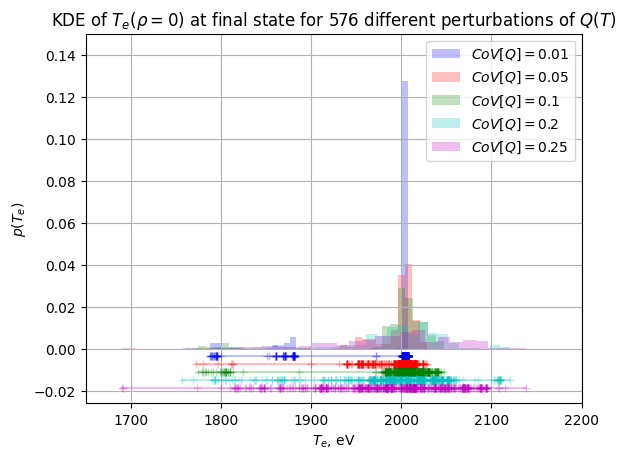

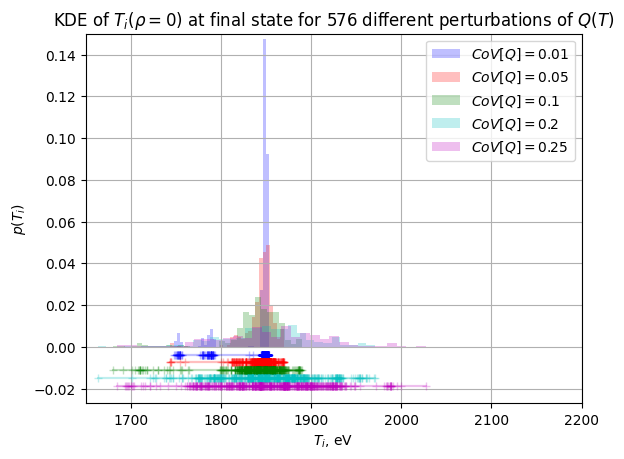

In [7]:
# Plot the KDE of T_0: look up /basicad/da_utils.py
from sklearn.neighbors import KernelDensity


output_columns =  ["te_value_0", "te_value_15", "te_value_30", "te_value_45", "te_value_57", "te_value_67", "te_value_77", "te_value_87", "te_value_95", 
                   "ti_value_0", "ti_value_15", "ti_value_30", "ti_value_45", "ti_value_57", "ti_value_67", "ti_value_77", "ti_value_87", "ti_value_95",]
# Get the data 
result_filename_list = ['../results_aletoric_20240222/result_aleatoric_wf_cv0.01.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.05.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.1.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.2.pickle', '../results_aletoric_20240222/result_aleatoric_wf_cv0.25.pickle']
cov_inputs = [float(".".join([f.split('.')[-3][-1],f.split('.')[-2]])) for f in result_filename_list]
# cov_inputs = [0.05, 0.1,] 
# cov_inputs = [0.01, 0.05]

data_list = []
# should be (at least) 3D data-structure: n_qoi x n_statistics x n_runs
for filename in result_filename_list:
    with open(filename, "rb") as f:
        data = pickle.load(f)
    data_list.append(data.samples[output_columns])

# General independent params

ind_coords = [0, 15, 30, 45, 57, 67, 77, 87, 95]
ft_coords = [0.143587306141853 , 0.309813886880875 , 0.442991137504578 , 0.560640752315521 , 0.668475985527039 , 0.769291400909424 , 0.864721715450287 , 0.955828309059143]
species = ['e', 'i']

n_scan_tries = len(cov_inputs)

n_runs = len(data_list[0].index)

ylim = 0.15 #n_runs #fraction is for KDE
xlim = (1650., 2200.)

dist_list  = [ylim*-2.5E-2*(i+1) for i in range(n_scan_tries)]
color_list = ['b', 'r', 'g', 'c', 'm', 'y']

alpha_transp = 0.25

nbins = 32
resol = 1024
expand_factor = 0.025

coord = 0

kde_kernel = 'gaussian' #'tophat'

for sp in species:

    fig, ax = plt.subplots()

    for i in range(len(data_list)):

        data = data_list[i][f"t{sp}_value_{coord}"]
        data = np.array(data)

        # make a KDE model: TODO automatic bw estimator
        bw = (data.max() - data.min()) / (nbins//4)
        kde = KernelDensity(kernel=kde_kernel, bandwidth=bw).fit(data)

        # prepare data for plotting
        x_plot = np.linspace(data.min()*(1-expand_factor),data.max()*(1+expand_factor), resol)[:, np.newaxis]
        log_dens = kde.score_samples(x_plot)

        # histogram
        norm = data.sum()
        ax.hist(data, bins=nbins, 
                density=True, histtype='stepfilled', 
                alpha=alpha_transp, color=color_list[i], label=f"$CV[Q]={cov_inputs[i]}$")

        # # KDE plot
        # ax.fill(x_plot[:, 0], np.exp(log_dens), 
        #         alpha=alpha_transp,
        #         color=color_list[i],
        #         label=f"$CV[Q]={cov_inputs[i]}$")

        # pluses for individual readings
        ax.plot(data[:, 0], np.full(data.shape[0], dist_list[i]), marker="+", color=color_list[i], alpha=alpha_transp)
    
    ax.set_ylim(ymax=ylim)
    ax.set_xlim(xlim)

    ax.legend(loc='best')
    ax.set_xlabel(f"$T_{sp}$, eV")
    ax.set_ylabel(f"$p(T_{sp})$") #(f"$p(\\cdot)$")
    ax.set_title(f"KDE of $T_{sp}(\\rho={coord})$ at final state for {n_runs} different perturbations of $Q(T)$")

    fig.savefig(f"gem0sur_aleatoric_kde_t{sp}.pdf")


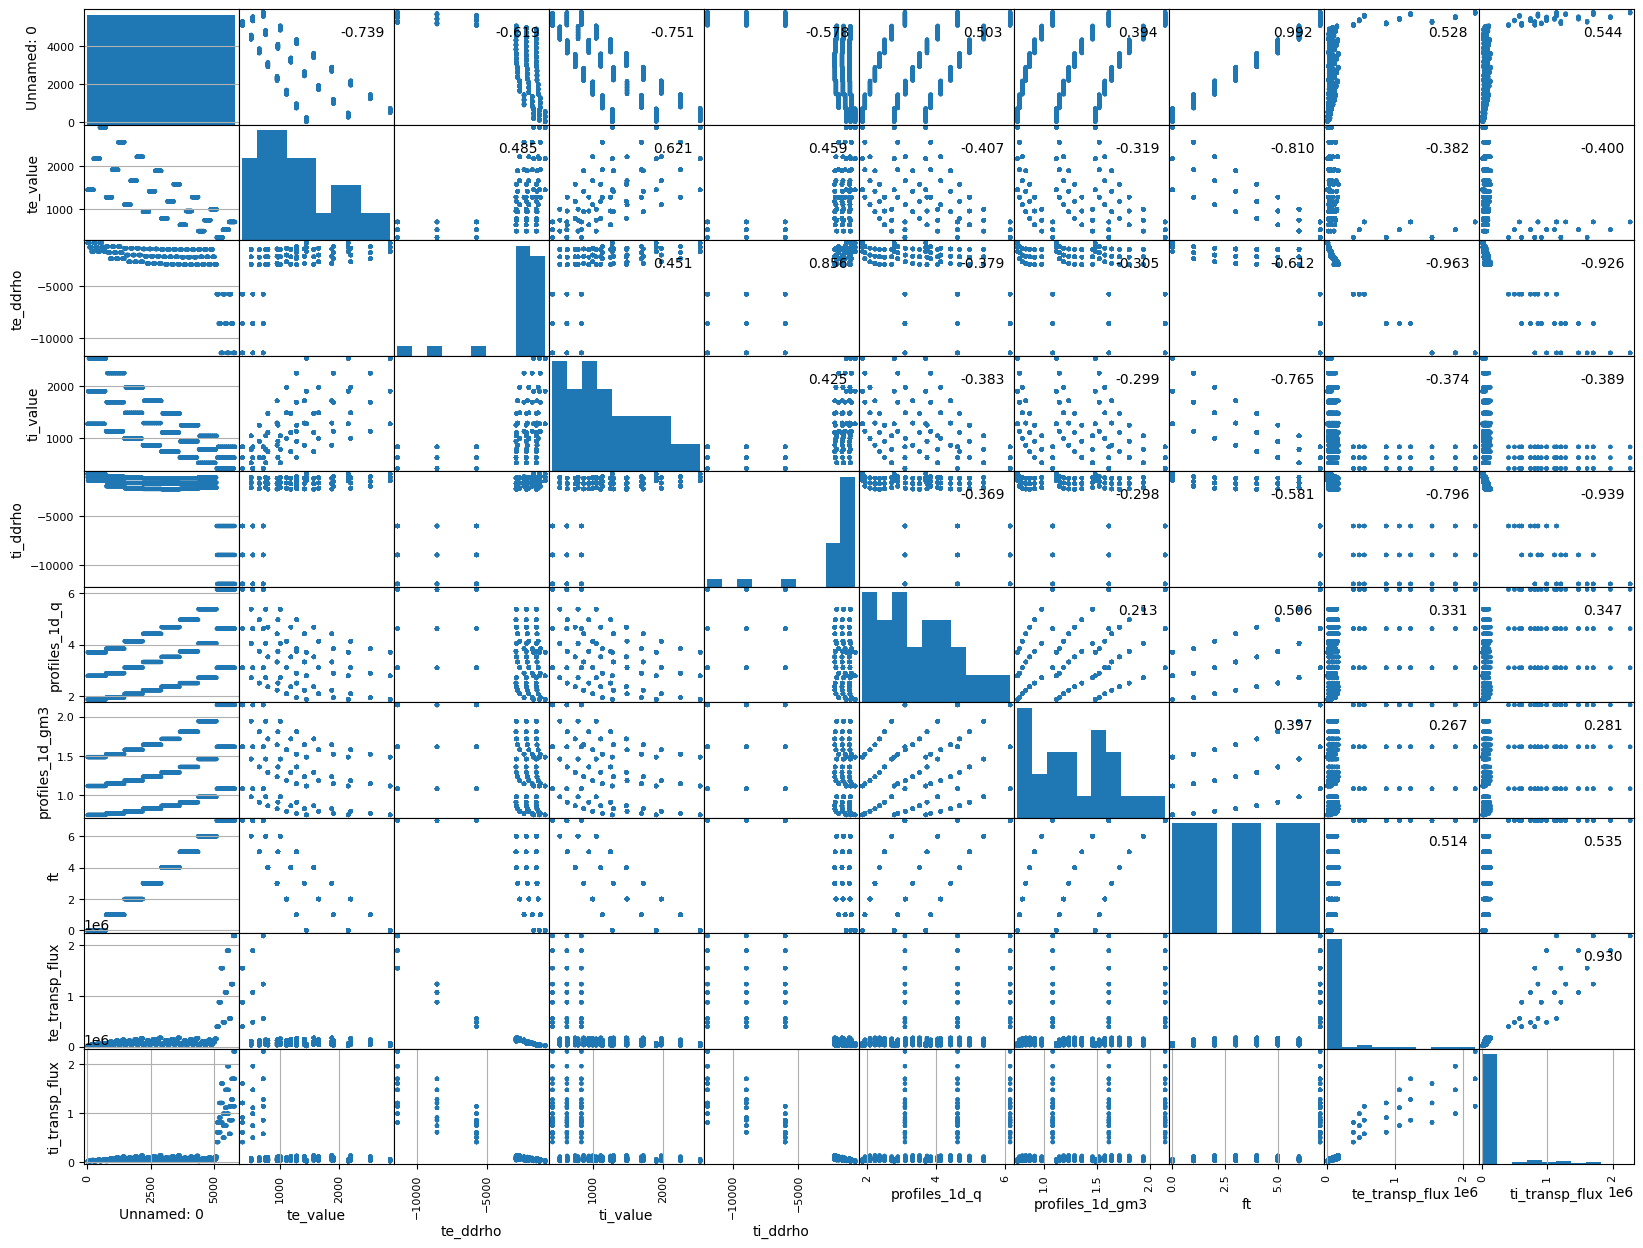

                            OLS Regression Results                            
Dep. Variable:         ti_transp_flux   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 1.645e+04
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:45:43   Log-Likelihood:                -74825.
No. Observations:                5832   AIC:                         1.497e+05
Df Residuals:                    5825   BIC:                         1.497e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.985e+05   8106.262    -

In [13]:
# Check the correlations in pyGEM0 data

filename = "gem0py_new_eqtest_1.csv"

# reading and selecting data
data = pd.read_csv(filename)
selected_cols = ['profiles_1d_q', 'profiles_1d_gm3', 'ti_transp_flux', 'te_transp_flux']
#data = data[selected_cols]

# plotting scatter-s and histograms
axes = pd.plotting.scatter_matrix(data, alpha=0.5, diagonal='hist', figsize=(20,15))

corr = np.array(data.corr())
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

# Anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols('ti_transp_flux ~ profiles_1d_q + profiles_1d_gm3 + ti_value + te_value + ti_ddrho + te_ddrho', data=data).fit()

print(lm.summary())
#print(sm.stats.anova_lm(cw_lm, typ=2))
